## Market Performance - Walk Score Analytics

### Project Overview

The project is focused on the exploration of walk score with real estate performance metrics of WeWork building. The scope is to understand our current performance as well as to uncover how the walk score relates to our current performance metrics.

In [57]:
import pandas as pd
import json
from pprint import pprint
import Module_Process as mp
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import seaborn as sns
%matplotlib inline
import folium
import matplotlib.pyplot as plt

### Table of Contents
* [Part 1. Market Data Enrichment](#Part-1.-Market-Data-Enrichment)
    * [1.1 Data Loading](#1.1-Data-Loading)
    * [1.2 Dataset Transformation and Data Type Conversion](#1.2-Dataset-Transformation-and-Data-Type-Conversion)
    * [1.3 Dataset Integration](#1.3-Dataset-Integration)
    * [1.4 Nan Value Processing](#1.4-Nan-Value-Processing)
    * [1.5 Dataset Export](#1.5-Dataset-Export)


* [Part 2. Geospatial Visualization](#Part-2.-Geospatial-Visualization)
    * [2.1 Feature Exploration](#2.1-Feature-Exploration)
    * [2.2 Visualization](#2.1-Visualization)
        * [2.2.1 Python Visualization](#2.2.1-Python-Visualization)
        * [2.2.2 QGIS Visualization](#2.2.2-QGIS-Visualization)
        * [2.2.3 WebGIS Portal Visualization](#2.2.3-WebGIS-Portal-Visualization)
   
   
* [Part 3. Variable Relationships Exploration](#Part-3.-Variable-Relationships-Exploration)
    * [3.1 Features Overview](#3.1-Features-Overview)
    * [3.2 Correlation Exploration](#3.2-Correlation-Exploration)
    * [3.3 Multivariants Plot](#3.3-Multivariants-Plot)
    * [3.4 Summary](#3.4-Summary)
    

### Part 1. Market Data Enrichment

### 1.1 Data Loading
#### 1.1.1 Wework Market Data - CSV 

In [58]:
#import pandas as pd
#import json
#from pprint import pprint

In [59]:
market=pd.read_csv('market_data.csv')
print (len(market))

41


In [60]:
market.dtypes

MARKET NAME             object
Total Inventory (SF)    object
Vacancy                 object
Asking Rent (USD/SF)    object
dtype: object

In [61]:
print (market.head())

       MARKET NAME Total Inventory (SF) Vacancy Asking Rent (USD/SF)
0     Philadelphia          135,570,108  12.70%              $26.43 
1  Washington D.C.          332,015,221  16.20%              $41.34 
2          Chicago          245,753,058  16.40%              $33.94 
3          Detroit           67,520,823  18.90%              $19.16 
4      Minneapolis           72,718,254  16.60%              $26.33 


#### 1.1.2 Walkscore Dataset - JSON file

In [62]:
with open('ws_data.json') as f:
    walk_score = json.load(f)

pprint(walk_score['Washington'])

{'date': 1528395746,
 'key': '910f0582fb65de286b0311fcded31d37',
 'lat': 38.9048,
 'lng': -77.0163,
 'page': 'c',
 'path': '/DC/Washington_D.C.',
 'price_range': [None, None],
 'slug': 'DC/Washington_D.C.',
 'sort_date': 1528395746,
 'thumb': 'https://pp2.walk.sc/s225/p/0/000000.jpg',
 'title': '1239-1259 16th Street Northwest',
 'walkscore': 91}


### 1.2 Dataset Transformation and Data Type Conversion
#### 1.2.1 Wework Market Dataset - Data Type Conversion

In [63]:
#String processing
market['Total Inventory (SF)']=market['Total Inventory (SF)'].str.replace(',','')
#Type conversion
market[['Total Inventory (SF)']]=market[['Total Inventory (SF)']].astype(float)

#String processing
market['Vacancy']=market['Vacancy'].str.replace('%','')
#Type conversion
market[['Vacancy']]=market[['Vacancy']].astype(float)


#String processing
market['Asking Rent (USD/SF)']=market['Asking Rent (USD/SF)'].str.replace('$','')
#Type conversion
market[['Asking Rent (USD/SF)']]=market[['Asking Rent (USD/SF)']].astype(float)

In [64]:
## Columns name update
market.columns=['MARKET NAME','Total Inventory (SF)','Vacancy%','Asking Rent (USD/SF)' ]

In [65]:
market.head()

,MARKET NAME,Total Inventory (SF),Vacancy%,Asking Rent (USD/SF)
0,Philadelphia,135570108.0,12.7,26.43
1,Washington D.C.,332015221.0,16.2,41.34
2,Chicago,245753058.0,16.4,33.94
3,Detroit,67520823.0,18.9,19.16
4,Minneapolis,72718254.0,16.6,26.33


#### 1.2.2 Walkscore Dataset - JSON file transformation and special character exclusion

In [66]:
score_csv=pd.DataFrame()
for key,item in walk_score.items():
    #print (key)
    score_csv=score_csv.append({'city':key,'lat':item['lat'],'lng':item['lng'],'walkscore':item['walkscore'],'path_state':item['path'].split('/')[1],'path_city':item['path'].split('/')[2].replace('_',' ')},ignore_index=True)

score_csv_copy= score_csv  # Used for the fuzzy string matche

In [67]:
print (len(score_csv))

99


In [68]:
score_csv.dtypes

city           object
lat           float64
lng           float64
path_city      object
path_state     object
walkscore     float64
dtype: object

In [69]:
score_csv.head()

,city,lat,lng,path_city,path_state,walkscore
0,New York,40.7238,-73.9764,New York,NY,96.0
1,Los Angeles,34.1070,-118.4120,Los Angeles,CA,5.0
2,Chicago,41.8369,-87.6848,Chicago,IL,41.0
3,Houston,29.7807,-95.3860,Houston,TX,72.0
4,Philadelphia,40.0076,-75.1340,Philadelphia,PA,75.0


##### Addtional Part  -  ** import module to process the json data [It is the replacement of 1.2.2]**

Here I wrote the transform function in the module which is the python file.It could be reused and simplified the code in json transformation work in the future. The output is the dataframe.

In [70]:
#import Module_Process as mp
test=mp.json_csv('ws_data.json','city','lat','lng','walkscore')
#pprint(test)

In [71]:
# how many distinct states in the walkability score dataset (in US, we have 50 statues in total)
#score_csv['path_state'].nunique()  # 34 States
#score_csv['path_state'].unique()

### 1.3 Dataset Integration

The merge process is undertook based on the market name and the city name in the two dataset. 

As the business concept and text varies in the market name and city name, in order to make full use the walk score dataset, I'm gonna using left join based on the market name provided in the wework market dataset.

In [72]:
market_full=pd.merge(market,score_csv,left_on='MARKET NAME',right_on='city',how='left')
market_full_copy=market_full # Used for the fuzzy string matches

In [73]:
market_full.head()

,MARKET NAME,Total Inventory (SF),Vacancy%,Asking Rent (USD/SF),city,lat,lng,path_city,path_state,walkscore
0,Philadelphia,135570108.0,12.7,26.43,Philadelphia,40.0076,-75.1340,Philadelphia,PA,75.0
1,Washington D.C.,332015221.0,16.2,41.34,NaN,NaN,NaN,NaN,NaN,NaN
2,Chicago,245753058.0,16.4,33.94,Chicago,41.8369,-87.6848,Chicago,IL,41.0
3,Detroit,67520823.0,18.9,19.16,Detroit,42.3834,-83.1024,Detroit,MI,37.0
4,Minneapolis,72718254.0,16.6,26.33,Minneapolis,44.9635,-93.2678,Minneapolis,MN,80.0


As what it is, there are some markets which didn't get the info from the walk score dataset, which I will deal with below in details. 

In [74]:
##  The 9 null records
null_checks=market_full.loc[market_full['city'].isnull()]
null_checks

,MARKET NAME,Total Inventory (SF),Vacancy%,Asking Rent (USD/SF),city,lat,lng,path_city,path_state,walkscore
1,Washington D.C.,332015221.0,16.2,41.34,NaN,NaN,NaN,NaN,NaN,NaN
10,Nashville,36281816.0,11.2,27.27,NaN,NaN,NaN,NaN,NaN,NaN
11,Raleigh-Durham,48150905.0,10.6,24.61,NaN,NaN,NaN,NaN,NaN,NaN
12,Brooklyn,47609232.0,20.0,46.92,NaN,NaN,NaN,NaN,NaN,NaN
13,Manhattan,23847963.0,8.5,72.48,NaN,NaN,NaN,NaN,NaN,NaN
18,Silicon Valley,70622781.0,19.4,49.92,NaN,NaN,NaN,NaN,NaN,NaN
20,Orange County,97702972.0,12.8,35.16,NaN,NaN,NaN,NaN,NaN,NaN
26,Salt Lake City,57606204.0,9.0,23.24,NaN,NaN,NaN,NaN,NaN,NaN
31,Tampa Bay,34893619.0,11.4,25.28,NaN,NaN,NaN,NaN,NaN,NaN


### 1.4 Nan Value Processing

Basically, there are three different situations related to the Nan value.

** 1). City names are slightly different from the market names.**

For this case, it is necessary to make it consistent in order to bring the walk score into the market dataset.

** 2). The market names didn't show up in the walk score json file. In this case, there are three different situations,**

- a. If the market name is based on the city level but still cannot bring in the walk score info, then the market is missing in the walk score dataset;

Here I tried to search that city in the walk score website. If it exists, we could manually bring the walk score info in. Otherwise, we will leave the walk score info as null.

- b. If the market is based on the region level that includes more than one cities, then the market info is missing in the walk score dataset;
  
I tried to use the average estimation based on relevant cities info in the extra section.But it is just the estimation, and won't be included in the visualization and analysis part later. 

- c. If the market is within city, then we might could get the estimation based on the all the relevant cities walk score info.

As the dataset doesn't contain that detailed info, I tried to use that city data to fill in the all the markets within that city. But it is just the estimation, and won't be considered in the visualization and analysis part.

#### 1.4.1 Deal with the Nans on similar market and city names [Situation 1]

In [75]:
## 1. City name are slightly different from the market name
#Washington -- Washington D.C.
score_csv.loc[score_csv['city']=='Washington','city']='Washington D.C.'
#Nashville-Davidson  --  Nashville
score_csv.loc[score_csv['city']=='Nashville-Davidson','city']='Nashville'
#Tampa --  Tampa Bay   as Tampa Bay is the part of the Tampa
score_csv.loc[score_csv['city']=='Tampa','city']='Tampa Bay'

# Brooklyn/Manhattan/Silicon Valley/Orange County/Salt Lake City

##### Advanced Part -Match data based on text similarity [Replacement of Part 1.4.1]

Since the flexibility is rooted in the text or string itself, in order to manually find the matched one, we could use fuzzy string matched method.

Here I am gonna using this method to help identify the potential matched city info with walk score for that null 9 records. The result is the same as the output went through the Part 1.4.1.

In [76]:
#from fuzzywuzzy import fuzz
#from fuzzywuzzy import process

In [77]:
market_name=null_checks['MARKET NAME']
city_name=score_csv_copy['city']
output={}
score=[]
for i in market_name:
    output[i]=process.extractOne(i, city_name) # return the top matched string in the city_name list
output

{'Brooklyn': ('Boston', 57, 23),
 'Manhattan': ('Omaha', 72, 40),
 'Nashville': ('Nashville', 100, 24),
 'Orange County': ('Orlando', 53, 75),
 'Raleigh-Durham': ('Raleigh', 90, 41),
 'Salt Lake City': ('Mesa', 64, 36),
 'Silicon Valley': ('Lincoln', 64, 70),
 'Tampa Bay': ('Tampa Bay', 100, 51),
 'Washington D.C.': ('Washington D.C.', 100, 22)}

In [78]:
for key, item in output.items():
    if item[1]>=90:
        #print (item)
        market_full_copy.loc[market_full_copy['MARKET NAME']==key,'walkscore']=score_csv_copy.loc[score_csv_copy['city']==item[0],'walkscore'].values[0]
        market_full_copy.loc[market_full_copy['MARKET NAME']==key,'city']=item[0]
        market_full_copy.loc[market_full_copy['MARKET NAME']==key,'lat']=score_csv_copy.loc[score_csv_copy['city']==item[0],'lat'].values[0]
        market_full_copy.loc[market_full_copy['MARKET NAME']==key,'lng']=score_csv_copy.loc[score_csv_copy['city']==item[0],'lng'].values[0]
        market_full_copy.loc[market_full_copy['MARKET NAME']==key,'path_city']=score_csv_copy.loc[score_csv_copy['city']==item[0],'path_city'].values[0]
        market_full_copy.loc[market_full_copy['MARKET NAME']==key,'path_state']=score_csv_copy.loc[score_csv_copy['city']==item[0],'path_state'].values[0]
       

In [79]:
market_full_copy.loc[market_full_copy['city'].isnull()]

,MARKET NAME,Total Inventory (SF),Vacancy%,Asking Rent (USD/SF),city,lat,lng,path_city,path_state,walkscore
12,Brooklyn,47609232.0,20.0,46.92,NaN,NaN,NaN,NaN,NaN,NaN
13,Manhattan,23847963.0,8.5,72.48,NaN,NaN,NaN,NaN,NaN,NaN
18,Silicon Valley,70622781.0,19.4,49.92,NaN,NaN,NaN,NaN,NaN,NaN
20,Orange County,97702972.0,12.8,35.16,NaN,NaN,NaN,NaN,NaN,NaN
26,Salt Lake City,57606204.0,9.0,23.24,NaN,NaN,NaN,NaN,NaN,NaN


As we could see, some of the Nan records are fixed based on the similarity between the market name and the city name. 
All the other Nan records are within the second situation, which require manual work to fix.

#### 1.4.2 Deal with the Nans on various market and city names [Situation 2]
##### Situation 2.a The market name is missing in the json file

In [80]:
# 2.a The city is missing in the json file
# Salt Lake City is not in the json file, so I did the manual search in the walk score website

#new_row=['Salt Lake City','40.7608','-111.8910','Salt Lake City','UT','57']
score_csv=score_csv.append({'city':'Salt Lake City','lat':40.7608,'lng':-111.8910,'walkscore':57,'path_state':'UT','path_city':'Salt Lake City'},ignore_index=True)


##### Situation 2.b The market is on the region level

As we could see, Silicon valley, Orange County, and Raleigh-Durham include more than one city in its market scope.
For Raleigh-Durham, I will simply estimate the walk score based on the average value of the two cities. For the other two, it is hard to get all the involved cities info, so I will not deal with it for now.

In [81]:
# Some markets are not in the city level, which can't bring the exact walk score info

# Raleigh-Durham -- in walk score dataset, Raleigh and Durham are two cities appeared seperately
#In order to bring the info based on the market Raleigh-Durham, I will bring average value of that two cities

Raleigh_walkscore=score_csv.loc[score_csv['city']=='Raleigh']['walkscore'].values[0]
Durham_walkscore=score_csv.loc[score_csv['city']=='Durham']['walkscore'].values[0]
Raleigh_lat=score_csv.loc[score_csv['city']=='Raleigh']['lat'].values[0]
Durham_lat=score_csv.loc[score_csv['city']=='Durham']['lat'].values[0]
Raleigh_lng=score_csv.loc[score_csv['city']=='Raleigh']['lng'].values[0]
Durham_lng=score_csv.loc[score_csv['city']=='Durham']['lng'].values[0]

score_csv=score_csv.append({'city':'Raleigh-Durham','lat':(Raleigh_lat+Durham_lat)/2,'lng':(Raleigh_lng+Durham_lng)/2,'walkscore':(Raleigh_walkscore+Durham_walkscore)/2,'path_state':'NC','path_city':'Raleigh-Durham'},ignore_index=True)

# Brooklyn/Manhattan/Silicon Valley/Orange County/Raleigh-Durham


In [82]:
market_full=pd.merge(market,score_csv,left_on='MARKET NAME',right_on='city',how='inner')

##### Try out -Other special cases on the Nan value

I tried to deal with some left cases in the nan value section here. But the output won't be used for the analysis later as the estimated walkscore need to be cross checked .

In [83]:
market_full2=pd.merge(market,score_csv,left_on='MARKET NAME',right_on='city',how='left')

In [84]:
## Special Case
# There is no detailed walk score for boroughs in New York, so using new york overall score to fill in instead of the null value.
#score_csv.loc[score_csv['city']=='New York']
market_full2.loc[market_full2['MARKET NAME']=='Brooklyn','city']='Brooklyn'
market_full2.loc[market_full2['MARKET NAME']=='Brooklyn','lat']=40.6782
market_full2.loc[market_full2['MARKET NAME']=='Brooklyn','lng']=-73.9442
market_full2.loc[market_full2['MARKET NAME']=='Brooklyn','path_city']='New York'
market_full2.loc[market_full2['MARKET NAME']=='Brooklyn','path_state']='NY'
market_full2.loc[market_full2['MARKET NAME']=='Brooklyn','walkscore']=score_csv.loc[score_csv['city']=='New York']['walkscore'].values[0]

market_full2.loc[market_full2['MARKET NAME']=='Manhattan','city']='Manhattan'
market_full2.loc[market_full2['MARKET NAME']=='Manhattan','lat']=40.7831
market_full2.loc[market_full2['MARKET NAME']=='Manhattan','lng']=-73.9712
market_full2.loc[market_full2['MARKET NAME']=='Manhattan','path_city']='New York'
market_full2.loc[market_full2['MARKET NAME']=='Manhattan','path_state']='NY'
market_full2.loc[market_full2['MARKET NAME']=='Manhattan','walkscore']=score_csv.loc[score_csv['city']=='New York']['walkscore'].values[0]


In [85]:
#Silicon Valley lies in the South Bay and the southern Peninsula of the San Francisco Bay Area, 
#which I will use the San Francisco info to fill in as the estimation.

market_full2.loc[market_full2['MARKET NAME']=='Silicon Valley','city']='San Francisco'
market_full2.loc[market_full2['MARKET NAME']=='Silicon Valley','lat']=37.3875
market_full2.loc[market_full2['MARKET NAME']=='Silicon Valley','lng']=-122.0575
market_full2.loc[market_full2['MARKET NAME']=='Silicon Valley','path_city']='San Francisco'
market_full2.loc[market_full2['MARKET NAME']=='Silicon Valley','path_state']='CA'
market_full2.loc[market_full2['MARKET NAME']=='Silicon Valley','walkscore']=score_csv.loc[score_csv['city']=='San Francisco']['walkscore'].values[0]

#Orange County market includes multiple cities, which I used the orange city in to fill in as the estimation.

market_full2.loc[market_full2['MARKET NAME']=='Orange County','city']='Orange'
market_full2.loc[market_full2['MARKET NAME']=='Orange County','lat']=33.7175
market_full2.loc[market_full2['MARKET NAME']=='Orange County','lng']=-117.8311
market_full2.loc[market_full2['MARKET NAME']=='Orange County','path_city']='Orange'
market_full2.loc[market_full2['MARKET NAME']=='Orange County','path_state']='CA'
market_full2.loc[market_full2['MARKET NAME']=='Orange County','walkscore']=51


### 1.5 Dataset Export

In [86]:
market_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 10 columns):
MARKET NAME             37 non-null object
Total Inventory (SF)    37 non-null float64
Vacancy%                37 non-null float64
Asking Rent (USD/SF)    37 non-null float64
city                    37 non-null object
lat                     37 non-null float64
lng                     37 non-null float64
path_city               37 non-null object
path_state              37 non-null object
walkscore               37 non-null float64
dtypes: float64(6), object(4)
memory usage: 3.2+ KB


In [87]:
market_full2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 10 columns):
MARKET NAME             41 non-null object
Total Inventory (SF)    41 non-null float64
Vacancy%                41 non-null float64
Asking Rent (USD/SF)    41 non-null float64
city                    41 non-null object
lat                     41 non-null float64
lng                     41 non-null float64
path_city               41 non-null object
path_state              41 non-null object
walkscore               41 non-null float64
dtypes: float64(6), object(4)
memory usage: 3.5+ KB


In [88]:
# Only including the matched records (It will be used for the visualization and analysis)
market_full.to_csv('Market_Info_CityOnly.csv',sep=',',index = False,encoding='utf-8')
# Including the matched records as well as the estimation records
#market_full2.to_csv('Market_Info_full.csv',sep=',',index = False,encoding='utf-8')

### Part 2. Geospatial Visualization

For the geospatial visualization, I plan to use three different ways to visualize the market with the walkscore and vacancy info seperately.

** Dimension: ** a. Walkscore b. Vacancy%

** Visualization Method**

- Python 
- GIS software (PostgreSQL+QGIS)
- Web Map Portal (CartoDB)

### 2.1 Feature Exploration

Before visualizing walkscore or vacancy info,feature exploration would help us to set the class range on the map.

In [89]:
#import seaborn as sns
#%matplotlib inline

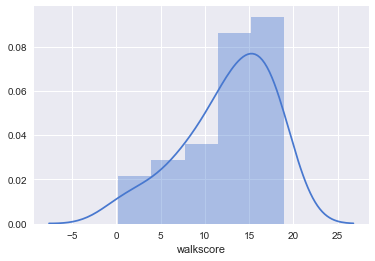

In [90]:
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
sns.distplot(market_full["walkscore"].dropna()/5);

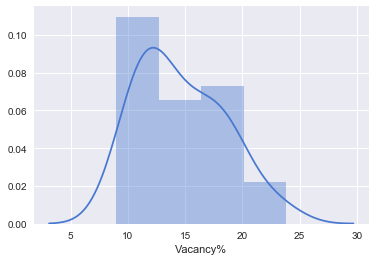

In [91]:
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
sns.distplot(market_full["Vacancy%"]);

### 2.2 Visualization

As the markets are based on the specific longitude and latitude, I plan to use the dot map with color-coded or the bubble map with size-coded.

Actually the bubble map could incorporate two dimensions of the dataset, but in order to show it more clearly,I plotted seperately in two layers using dot map and bubble map.

#### 2.2.1 Python Visualization

In [92]:
#import folium
#from folium.plugins import MarkerCluster

In [93]:
folium_map = folium.Map(location=[37.0902, -95.7129],
                        zoom_start=4)

In [94]:
for index, row in market_full.iterrows():
    #print (row['walkscore'])
    value = row['Vacancy%']
    radius = row['walkscore']/4
    
    if value<=12:
        color="#DAF7A6"
    elif value>12 and value<=14 :
        color="#FFC300" 
    elif value>14 and value<=16 :
        color="#F99002" 
    elif value>16 and value<=18 :
        color="#F95C02" 
    else:
        color="#F90202" 
    
    ## add marker
    popup_text = "Market Name: {}<br> Walk Score: {}<br> Vacancy%: {}"
    popup_text = popup_text.format(row["MARKET NAME"],
                               row["walkscore"],
                                  row['Vacancy%'])
    
    folium.CircleMarker(location=(row["lat"],
                                  row["lng"]),
                        radius=radius,
                        fill=True,
                       popup=popup_text).add_to(folium_map)
    
    folium.CircleMarker(location=(row["lat"],
                                  row["lng"]),
                        radius=1,
                        color=color,
                        fill=True,
                       popup=popup_text).add_to(folium_map)
    

In [95]:
folium_map

#### 2.2.2 QGIS Visualization

The visualization is done through PostgreSQL and QGIS. The detailed process is below,
- Import the csv data into the postgreSQL.
- Import the dataset into QGIS based on the connection with postgreSQL.
- Define coordinate system using EPSG:4326 - WGS 84.
- Define symbology and display and design the thematic map.

Below is the QGIS Visualization.

![alt text](Output\Part2_Graph2.png "Geospatial Visualization")

#### 2.2.3 WebGIS Portal Visualization

Here I choose the CartoDB to directly visualize it. The process is straight forward and visualization is very dynamic.

You could check the online visualization [here][].

[here]: https://rz992.carto.com/builder/26302c14-ceda-494c-ac11-2028dfbd7ae0/embed "WebGIS Visualization"


Below is the screenshot.

![visual3](Output\Part2_Graph3.png "Geospatial Visualization3")

#### 2.2.4 Observation

Based on the Geo visualization, 

- The market vacancy spread within 0-24%, and usually the markets along the sea (especially big cities at eastern and western coast) have the lower rate than the markets inland. The Great Lakes Region is the cluster of the markets with high vacancy.

- The walk score in general is relatively lower in inland market than its in coastal area. The markets which are clustered or nearby have the higher walk score compared to the independent market.

- Usually the markets clustered have the similarity in the vacancy dimension. One exception I identified is Austin-San Antonio-Huston which might be the potential to dive deep into for the market investment.

- Usually the market with higher walk score will have the lower market vacancy.



#### Extra Visualizaiton

Based on the three dimensions - Vacancy%, Total Inventory (SF), Asking Rent (USD/SF), we could estimate the potential supply and potential revenue in each market, which could help the company to identify and target the potentially beneficial market.

                    Potential Revenue = Vacancy%*Total Inventory (SF)*Asking Rent (USD/SF)

Below is the visualization for the potential revenue in each market. As what we could identify, the potential revenue is color coded and the vacancy is size coded. 

In order to understand our current markets, we could seperate the markets into three groups,
- High potential Revenue with high vacancy, such as Austin, Atlanta, and Dallas
- High potential Revenue with low vacancy, such as San Diego, Los Angeles,Boston
- Low potential Revenue, such as Columbus,St. Louis,Milwaukee

For the markets with high potential revenue and low vacancy, they are the markets that we built up and put efforts in  the past. They still could bring the potential revenue to us as the rent is relatively high, and we need to re-evaluate the market demand and consider to expand the capacity or not.

For the markets with high potential revenue and high vacancy, they are the second tier or the markets we should target and put more efforts on. We should do more campaigns in those cities in order to get more revenue as well as try to reduce the cost based on the vacancy.


![visual4](Output\Part2_Graph4.png "Geospatial Visualization4")

### Part 3. Variable Relationships Exploration

Plot the relationship between walk score and three real estate variables: inventory, vacancy, and asking rent (again using the tool of your choice). Discuss what patterns you see, if any, and briefly explain further steps you might take to explore this data.

### 3.1 Features Overview

In [96]:
market_full.head()

,MARKET NAME,Total Inventory (SF),Vacancy%,Asking Rent (USD/SF),city,lat,lng,path_city,path_state,walkscore
0,Philadelphia,135570108.0,12.7,26.43,Philadelphia,40.0076,-75.1340,Philadelphia,PA,75.0
1,Washington D.C.,332015221.0,16.2,41.34,Washington D.C.,38.9048,-77.0163,Washington D.C.,DC,91.0
2,Chicago,245753058.0,16.4,33.94,Chicago,41.8369,-87.6848,Chicago,IL,41.0
3,Detroit,67520823.0,18.9,19.16,Detroit,42.3834,-83.1024,Detroit,MI,37.0
4,Minneapolis,72718254.0,16.6,26.33,Minneapolis,44.9635,-93.2678,Minneapolis,MN,80.0


In [97]:
market_full.describe()

,Total Inventory (SF),Vacancy%,Asking Rent (USD/SF),lat,lng,walkscore
count,3.700000e+01,37.000000,37.000000,37.000000,37.000000,37.000000
mean,8.126841e+07,14.629730,27.897568,37.212412,-92.875499,62.797297
std,7.301468e+07,3.813927,10.345803,5.255447,15.544845,25.256864
min,1.520419e+07,9.000000,18.990000,25.775300,-122.650000,1.000000
25%,3.288863e+07,11.400000,20.110000,33.572400,-98.524700,47.000000
50%,5.186842e+07,14.200000,25.280000,38.635800,-87.684800,68.000000
75%,9.883481e+07,17.600000,30.800000,40.439600,-81.660200,86.000000
max,3.320152e+08,23.800000,74.640000,47.620200,-71.081500,95.000000


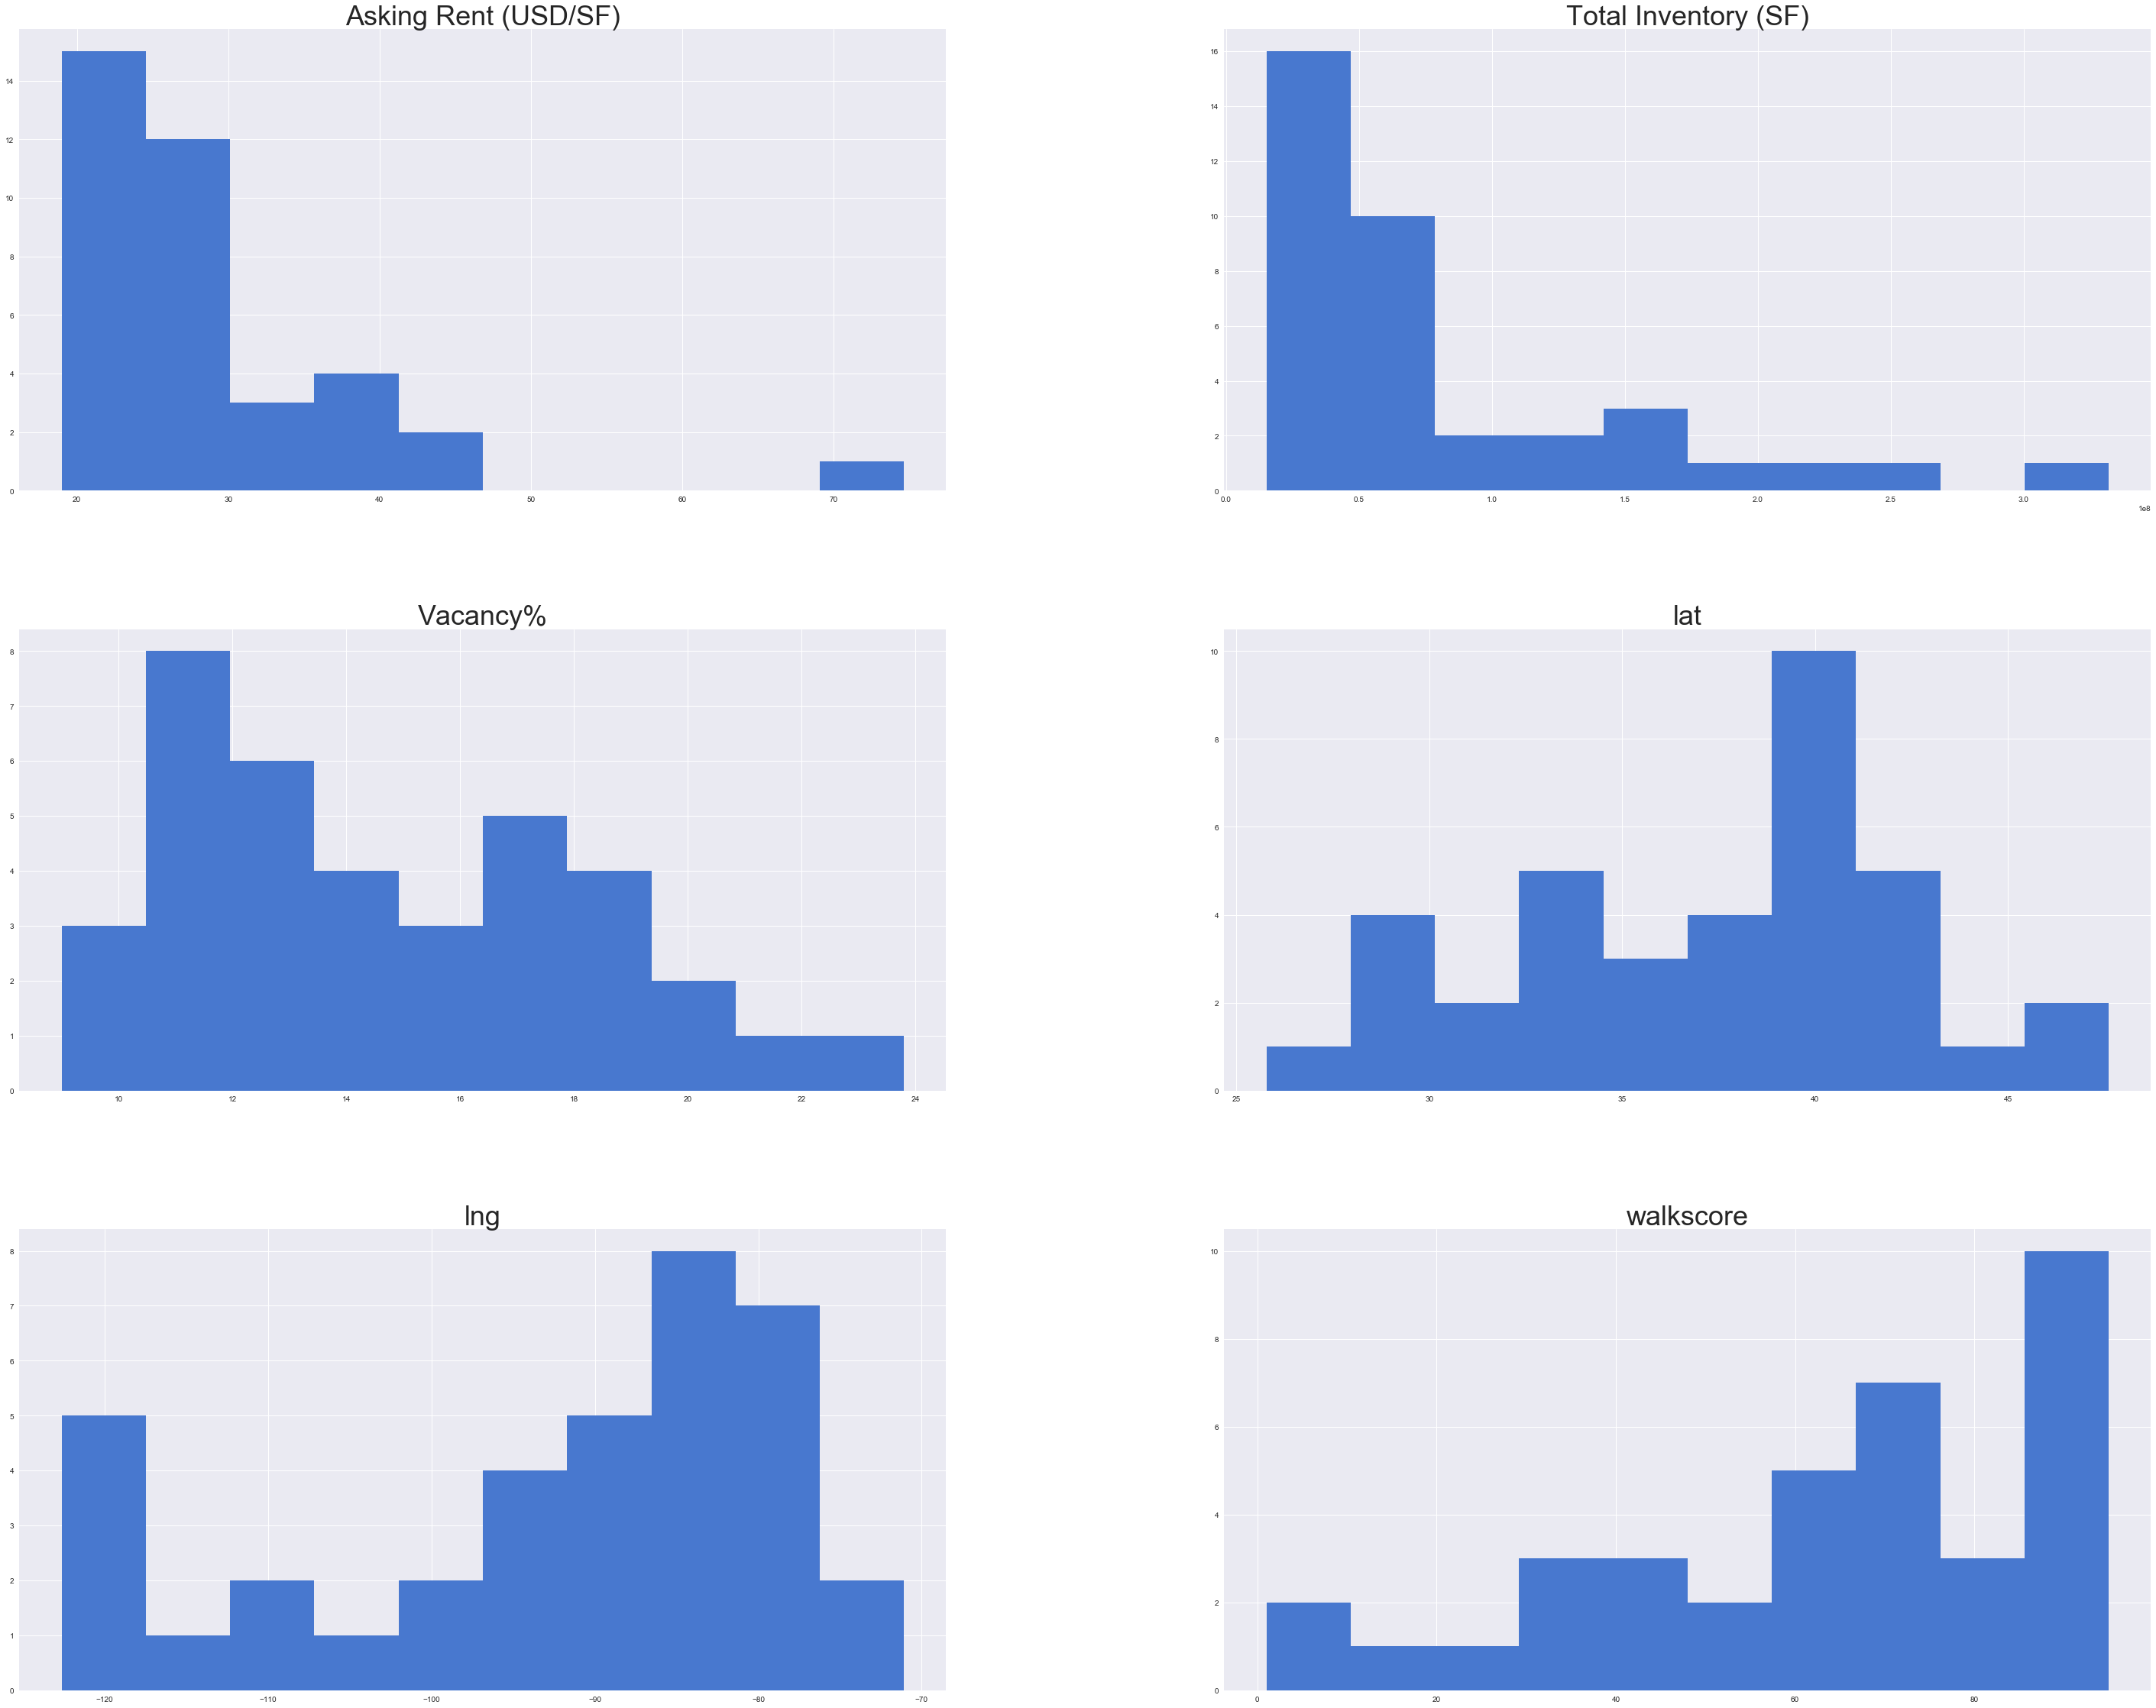

In [98]:
fig=market_full.hist(figsize=(50, 40))
draw=[x.title.set_size(36)for x in fig.ravel()]

__Observation:__
From the distribution on each varaible, we could see the total inventory and asking rent are right-skewed distributed and the walkscore is more left-skewed distributed. 

Instead of showing each distribution seperately, I brought our targeted variables into the same histgram below, which provide the feeling on how they potentially impact each other.

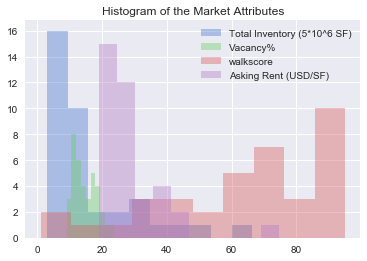

In [ ]:
plt.hist(market_full['Total Inventory (SF)']/5000000, alpha=0.4, label='Total Inventory (5*10^6 SF)')
plt.hist(market_full['Vacancy%'], alpha=0.4, label='Vacancy%')
plt.hist(market_full['walkscore'], alpha=0.4, label='walkscore')
plt.hist(market_full['Asking Rent (USD/SF)'], alpha=0.4, label='Asking Rent (USD/SF)')
plt.legend(loc='upper right')
plt.title('Histogram of the Market Attributes')
plt.show()

### 3.2 Correlation Exploration

In [ ]:
sns.set(color_codes=True)
sns.pairplot(market_full,size=2)

From the dot charts above with the walkscore, there is not a clear trend bewteen walkscore and any other variables. But in general, there are more markets within 50-100 in walkscore. 

So, I will check out the correlation between variables and bring the heatmap in.

In [ ]:
corr=market_full.corr()
corr

In [ ]:
sns.heatmap(corr)

__Observation:__
As the heatmap represents, the pattern beween walkscore and other variables are more obvious. The walkscore is positively correlated with the asking rent, which means the rent is higher, the walkscore is higher. On the other hand, Vacancy is slightly and negatively related to the walkscore, which means that if the vacancy is higher, the walkscore will be lower. The total inventory here is not that relevant to the walkscore.

In order to represent and justify it visually, I tried the linear regression model below to visualize how each variable correlated with walkscore.

In [ ]:
sns.set_style('whitegrid')
sns.regplot(x='walkscore',y='Asking Rent (USD/SF)',data=market_full,ci =95,robust=True)

In [ ]:
sns.set_style('whitegrid')
sns.regplot(x='walkscore',y='Vacancy%',data=market_full)

In [ ]:
sns.set_style('whitegrid')
sns.regplot(x='walkscore',y='Total Inventory (SF)',data=market_full)

### 3.3 Multivariants Plot

Below instead of looking at two vairables, I plan to check out the multivariables charts in order to identify more patterns. 

[Tableau]
![visual5](Output\Part3_Chart1.png "Exploreation Visualization")


At the same time, rather than showing the walk score as one continuous measurement in tableau, I break the walk score into 5 groups based on the reference in order to clarify any potential pattern. 

![visual6](Output\Part3_Chart2.png "Exploreation Visualization2")

**Based on the chart above,** 

if we look at the markets with 90-100 walkscore, they generally have low vacancy, relative high rent price and small inventory. 

If we move to the markets with medium range of walkscore, the real estate features are varied. But the market with higher rent tend to have better walkscore. The vacancy start to varied and increase especially from the 80-90 walkscore group to 50-60 walkscore group.Addtionally, market with large inventory will start apprear in the medium range of walkscore group.

For the market with walkscore (below 50), it tends to have low asking rent, high vacancy and varied inventory.

### 3.4 Summary

** Pattern **

Based on the charts and statistics analysis, we could uncover some potential patterns among walkscore, vacancy, ask rent and total inventory.

- If the markets'vacancy is extremely low, then the market tends to have higher walkscore.
- If the market with extremely high asking rent, then the market tends to have higher walkscore.

Based on the high/medium/low walks core group,

- Usually the high walkscore group is well-developed region or market,and they generally have low vacancy, relative high rent price and small inventory. 

- On the other hand, for the low walkscore group,the markets tend to have low rent, high vacancy and varied inventory.

- With the medium walkscore group, the markets varied in the real estate features. But in general,the higher rent with lower vacancy tend to have higher walkscore.

** Plan **

In order to either justify my thoughts above or dive deep to fully understand the walkscore with other real estate features, it might be a good idea to implement multivariant regression model. Through that we could understand how the real estate features will reflect the walkscore through the coefficient or the feature importance. During that process, we could change the walk score to a categorical variable if the small difference in the walk score doesn't imply much info.

With the verification above, it will be helpful to us to evaluate our current market perfomance, as well as serve as an indicator for the potential market identification. 